In [14]:
import pyddm
import numpy as np
import random
import pandas as pd
from riskyneuroarousal.utils.ddm_sample_generator import (get_ddm_model_2, 
                                                          get_model_samples)
import seaborn as sns

In [265]:
x0=0.3
drift = 0.3
nondecision=0.2
bound=1
theta=0.8
alpha=0.9
lambd=1.5
c = 1

In [266]:
model = get_ddm_model_2(x0=x0, 
                        drift=drift, 
                        nondecision=nondecision, 
                        bound=bound, 
                        theta=theta, 
                        alpha=alpha, 
                        lambd=lambd, 
                        c=c)

In [267]:
def get_trials(gains, losses, repetitions = 1):
    trials = []
    for g in gains:
        for l in losses:
            trials += [{"gain": g, "loss": l}] * repetitions
    
    random.shuffle(trials)
    return pd.DataFrame(trials)

In [268]:
gains = np.arange(5, 21, 1)
gains2 = np.arange(10, 41, 2)
losses = np.arange(5, 21, 1)
trials = get_trials(gains, losses, repetitions=1)

In [269]:
trials["sub"] = 1
trials["condition"] = 'equalRange'

In [270]:
sim = get_model_samples(trials, model, samples_per_condition=50)

<Axes: xlabel='RT', ylabel='Count'>

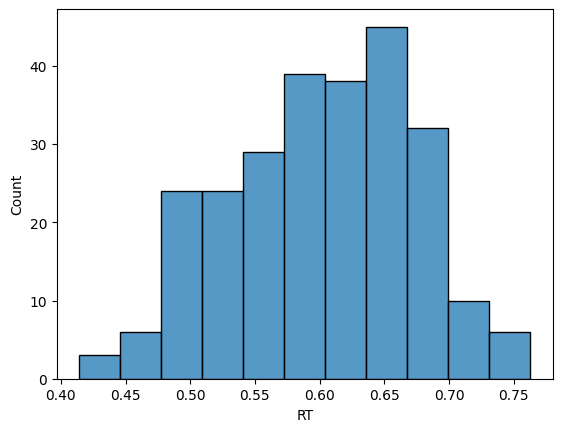

In [271]:
sns.histplot(data=sim, x="RT")

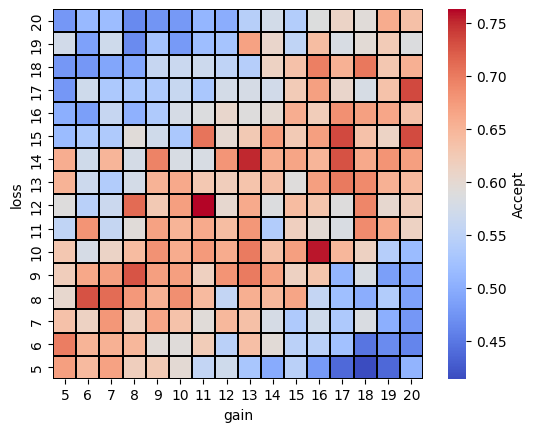

In [272]:
hmap_data = sim.groupby(['loss', 'gain'])['RT'].mean().unstack()
# Reverse the order of gain
hmap_data = hmap_data.iloc[::-1]
ax = sns.heatmap(hmap_data, cmap='coolwarm', cbar_kws={'label': 'Accept'}, square=True, linewidths=0.2, linecolor='black', cbar = True)

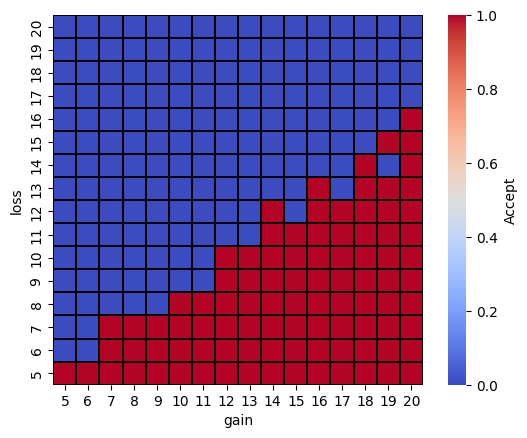

In [273]:
hmap_data = sim.groupby(['loss', 'gain'])['accept'].mean().unstack()
# Reverse the order of gain
hmap_data = hmap_data.iloc[::-1]
ax = sns.heatmap(hmap_data, cmap='coolwarm', cbar_kws={'label': 'Accept'}, square=True, linewidths=0.2, linecolor='black', cbar = True)